In [11]:
import numpy as np
import torch
import sklearn

import random
import sys
from tabnanny import verbose
import traceback
import gc
from pathlib import Path
from pdb import set_trace as st

import matplotlib.pyplot as plt
import scipy
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import torchaudio
from tqdm import tqdm

In [77]:
from sklearn .metrics import roc_auc_score

# demo code
 
y_true = [1, 1, 0, 0, 1, 0]
y_pred = [0.95, 0.90, 0.85, 0.81, 0.78, 0.70]
auc = np.round(roc_auc_score(y_true, y_pred), 3)
print("Auc for our sample data is {}".format(auc))

Auc for our sample data is 0.778


In [5]:
# load ckpt

from tqdm import tqdm

from data import EEG_Standard

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_blk_idx=0
train_tone_idx=3

test_blk_idx = train_blk_idx
test_tone_idx = train_tone_idx

train_split_ratio=0.8 # how many samples to use for training
epoch=20

In [19]:
test_set = EEG_Standard(blk_idx=test_blk_idx, tone_idx=test_tone_idx, training=False, train_split_ratio=train_split_ratio)

batch_size = 32

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    # collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True,
)

pos in test 330


In [7]:
ckpt = torch.load(f'out/{train_split_ratio}-{train_blk_idx}-{train_tone_idx}-epoch{epoch}.pt')

In [13]:
class M5(nn.Module):

    def __init__(self, n_input=1, n_output=35, stride=1, n_channel=32):
        super().__init__()
        # self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.conv1 = nn.Conv1d(
            n_input, n_channel, kernel_size=16,
            stride=stride)  # 358 / 20 ~= 18, receptive field = 20ms
        self.bn1 = nn.BatchNorm1d(n_channel)
        # self.pool1 = nn.MaxPool1d(4)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        # self.pool2 = nn.MaxPool1d(4)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        # self.pool3 = nn.MaxPool1d(4)
        self.pool3 = nn.MaxPool1d(2)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        # self.pool4 = nn.MaxPool1d(4)
        self.pool4 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        # print(x.shape)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        # print(x.shape)
        x = self.conv3(x)
        # print(x.shape)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        # print(x.shape)
        x = self.conv4(x)
        # print(x.shape)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

waveform, label = test_set[
    0]  # 1*358*64, 1/2/3/4, cntl/tinn, 0/1


# TODO, tune the parameters
model = M5(n_input=waveform.shape[0], n_output=2,
           n_channel=32)  # binary classification
model.to(device)
# print(model)
model.load_state_dict(ckpt)

<All keys matched successfully>

In [105]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)



import pdb

torch.inference_mode()
def test(model, epoch):
    model.eval()
    correct = 0
    true_prob = []
    gt = []
    with torch.no_grad():
        for data, target in test_loader:
    
            data = data.to(device)
            target = target.to(device)
    
            # apply transform and model on whole batch directly on device
            # data = transform(data)
            output = model(data)
    
            # pdb.set_trace()
            true_prob.append(torch.exp(output)) # probability of "1"
            gt.append(target)
            
            pred = get_likely_index(output)
            correct += number_of_correct(pred, target)
    
            # update progress bar
            # pbar.update(pbar_update)

    print(
        f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.2f}%)\n"
    )
    return true_prob, gt

In [106]:
true_prob, gt = test(model, epoch)
true_prob = torch.cat(true_prob).cpu().squeeze(1).numpy()
gt = torch.cat(gt).cpu().numpy()


Test Epoch: 20	Accuracy: 585/638 (91.69%)



In [107]:
true_prob.shape

(638, 2)

In [108]:
gt.shape

(638,)

In [84]:
# auc = np.round(roc_auc_score(y_true, y_pred), 3)
auc = np.round(roc_auc_score(gt, true_prob), 3)
print("Auc for our sample data is {}".format(auc))

Auc for our sample data is 0.973


In [98]:
print(gt.shape)
print(true_prob.shape)

(638,)
(638, 1, 2)


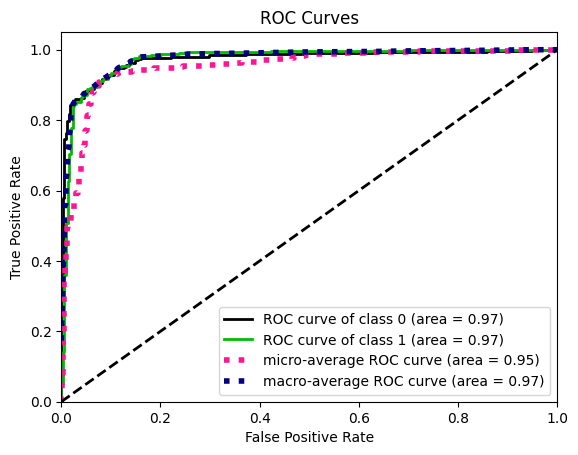

In [109]:
# ! pip install scikit-plot


import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc(gt, true_prob)
plt.show()

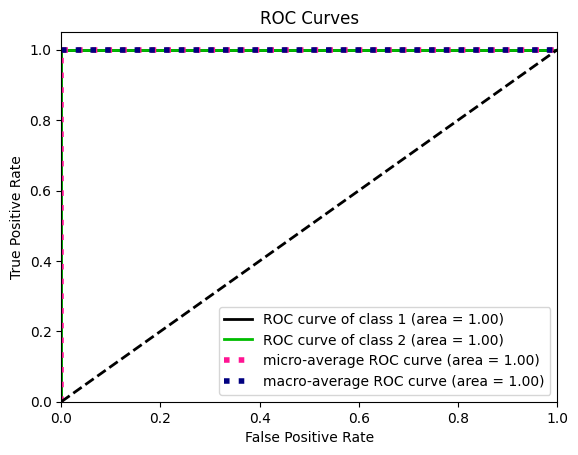

In [86]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()


X_train = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
y_train = np.array([1, 1, 1, 2, 2, 2])


nb = nb.fit(X_train, y_train)
y_probas = nb.predict_proba(X_train)
skplt.metrics.plot_roc(y_train, y_probas)
plt.show()

In [96]:
y_probas.shape

(6, 2)

In [97]:
y_train.shape

(6,)